# M5 Forecasting Competition
![](http://storage.googleapis.com/kaggle-competitions/kaggle/18599/logos/thumb76_76.png?t=2020-02-07-00-58-17)

For the last few weeks I have been running some analyses on the raw data for M5 forecasting challenge. The objective of this notebook is to provide a overview of the raw data files and establishing some benchmarks using basic time series forecasting techniques. I also made a submission using the Croston method - which is suitable for time series with intermittent demand.

# Table of Contents - 
* [Importing the raw datasets & basic overview of datasets](#introduction)
* [Data Transformations](#DataTransformations)
* [Impact of SNAP days on sales](#snap)
* [Impact of events on Sales](#events)
* [Relationship between Price & Demand](#corprice)
* [Variation in prices over time and across stores](#pricevar)
* [Time Series Analysis - Overall trend & Seasonality](#tsa)
* [Benchmarking using basic time series forecasting techniques(Naive, Seasonal Naive, Moving Average, Exponential Smoothing, Croston Method)](#forecast)
* [Forecasting using Croston Method](#croston)

## Importing the Raw Datasets<a name="introduction"></a>

The Competiton provides the following files - 

```calendar.csv```- Contains information about the dates on which the products are sold.

```sales_train_validation.csv``` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

```sample_submission.csv``` - The correct format for submissions. Reference the Evaluation tab for more info.

```sell_prices.csv``` - Contains information about the price of the products sold per store and date.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import os
import csv
import datetime as datetime
import json 
import datetime as dttm #time/date manipulations
import sklearn
#import matplotlib.pyplot as plot#Matplotlib
#import seaborn as sns
import numpy as np
import math
import keras
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pylab as plab

from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
## load the data
sales_train = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sample_submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

#Print dimensions of dataframe
print(sales_train.shape)
print(sell_prices.shape)
print(calendar.shape)


#Print first few rows of the data frame
print(sales_train.head())
print(sell_prices.head())
print(calendar.head())

## Overview of data - 

Quick look at the dataset reveals the following details - 

### sales_train-
* The raw data provides item_id level daily sales for **30,490 items across different product categories across different stores**
* Each time series provides data for **1913 unique dates**. Upon closer inspection you also find that **lot of values in the time series are actually zero, which indicates that this maybe a time series with intermittent demand**
* The sales data is provided for 3 categories - **Hobbies, Foods & Household**. Each of the product falls under one of these three categories
* The sales data is provided for 10 stores across 3 states - **4 in CA, 3 in WI & 3 in TX**


### calendar -
* The calendar data contains data for **1969 unique dates**, all the dates within ```sales_train``` are included in this dataset
* The calendar dataset provides details around which dates fall on various cultural, religious, sporting events etc. 
* Additionally there are three flag columns signifying whether a particular date is SNAP day or not in the state. A quick google search reveals that SNAP refers to Supplemental Nutritional Assistance Program - which is a means for low income households to purchase food at discount prices during certain days in a month. For more details read here - [https://en.wikipedia.org/wiki/Supplemental_Nutrition_Assistance_Program](http://)

### sell prices -
* This dataset has more than **6.8 Million unique records**
* This dataset provides daily price values for all items available in the sales_train dataset across all stores
* Prices are available from the date a product was launched

### sample submission -
* Sample submission file format. For this competition we need to submit 28 days of daily forecast values of qty sold for each of the time series. 


## Potential Areas of Analysis 

Given all we now have a basic understanding of the different data files, we can now look at further areas of analysis to get a deeper understanding of variation of the time series for different products using the other raw datasets provided.

* In the printed output above we saw that there are lot of zero values within the time series. Let's also check the distribution of zero values across all time series in the datasets and find out how many of the values are zero
* How does the distribution of **zero** sales values varies across different states?
* What is the impact of **SNAP** days on overall sales? Do we see more sales for food items as compared to other days? 
* What is the impact of **events** on overall sales of products?
* Is there a **correlation** between item price values and overall sales?
* How does the total number of **unique products** sold across stores change over time?
* How do product prices change over time?
* How do item **price** values vary across product categories and stores?
* How do overall **sales** vary across stores? Which stores sell the **least** and **most** amount of items?

In [ ]:
#Check counts of non-zero values in all the time series - 
sales_prods= sales_train.loc[:, 'd_1' : ]
zero = sales_prods.apply(lambda x: x == 0)

k=zero.sum(axis=1)
k=k/1913
sales_train['zero_days']=k
#sales_train

hobbies=sales_train.loc[sales_train['cat_id']=='HOBBIES']
foods=sales_train.loc[sales_train['cat_id']=='FOODS']
household=sales_train.loc[sales_train['cat_id']=='HOUSEHOLD']
#print(sales_train.groupby(['cat_id']).agg({'zero_days': ['mean','median']}).reset_index())

fig = go.Figure()
fig.add_trace(go.Histogram(x=hobbies['zero_days'],name='Hobbies'))
fig.add_trace(go.Histogram(x=foods['zero_days'],name='Foods'))
fig.add_trace(go.Histogram(x=household['zero_days'],name='Household'))

# Overlay all histograms
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across Product Categories',xaxis_title_text='Proportion of Zero Values',yaxis_title_text='Count')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.1)

fig.show()

Each point on the histogram above corresponds to a time series. As we can see above - across all the three different product categories - the proportion of zero values is quite high. But between the three different categories - the peaks of histograms are quite different. **Generally Food products have least proportion of zero values whereas Household products have the highest proportion of zero values**

In [ ]:
#Checking how zero values vary by state
tx=sales_train.loc[sales_train['state_id']=='TX']
ca=sales_train.loc[sales_train['state_id']=='CA']
wi=sales_train.loc[sales_train['state_id']=='WI']


fig = go.Figure()
fig.add_trace(go.Histogram(x=tx['zero_days'],name='TX'))
fig.add_trace(go.Histogram(x=ca['zero_days'],name='CA'))
fig.add_trace(go.Histogram(x=wi['zero_days'],name='WI'))


# Overlay all histograms
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across States',xaxis_title_text='Proportion of Zero Values',yaxis_title_text='Count')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.3)

fig.show()

<a name="DataTransformations"></a>

The chart above suggests proportion of zero values across all three states follows a similar distribution therefore proportion of zero values isn't impacted by state. 

## Data Transformations

### Sampling sales train

I initially tried to run my code on the entire data frame, but it failed due to overusage of memory. There are two days to deal with this situation - 
1. **Downcasting** to reduce storage for individual data frames
2. Take a **random sample** of records in the dataframe

To learn more about how downcasting can actually reduce the storage required by the dataframe, read this excellent kernel [here](https://www.kaggle.com/anshuls235/m5-forecasting-eda-feature-engineering)

For this kernel i took the second approach of taking a **25% percent random sample** of the data frame.This will hopefully allow us to run code faster while providing similar patterns about the data as the entire dataset. We will also be **transposing** the dataframe from wide format to thin format to allow for easier data analysis involving summary and joins.

### Melting Sales Data

We will be converting the sales prices dataframe from wide format to long format. This will bring all the daily sales values to one column from 1913 separate columns and will allow us to run summary operations in an easier manner. This will also allow us to run join operations with other datasets like **calendar** and  **sell_prices** on date columns in a easier manner. Python's melt function allows us to do this in just a single line of code. 

You can read [this](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) Pandas documentation here to understand different kinds of functions used for data transformations

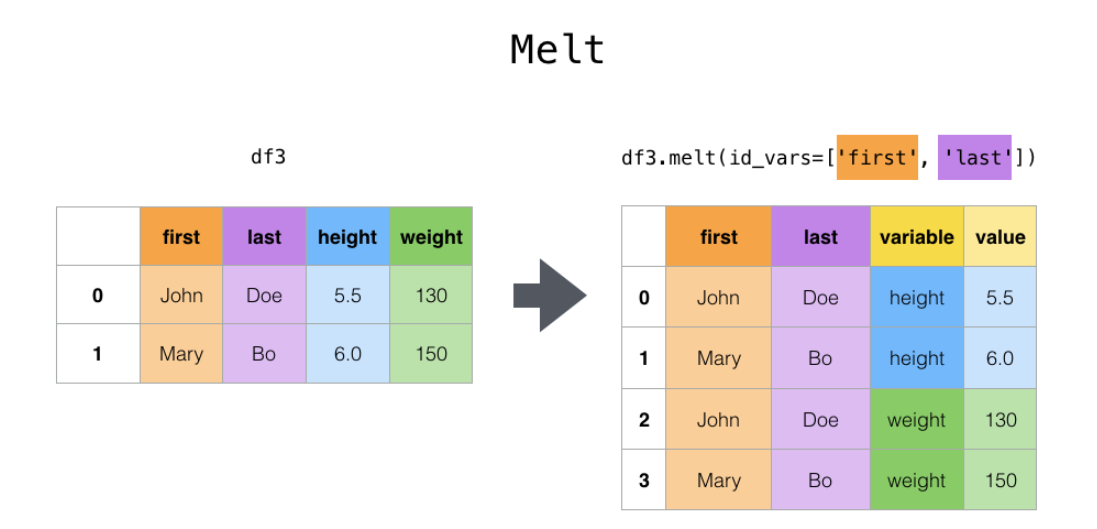
Similar to the image above we will keep columns ``'id','item_id','dept_id','cat_id','store_id','state_id'`` as id columns transforming the daily sales columns and converting it into a sales column, with another additional column added to track the date 

In [ ]:
#Sample dataframe to navigate tough waters ahead
print(sales_train.shape)

rows=int(sales_train.shape[0]/4)
sales_train=sales_train.sample(rows, replace=True)
print(sales_train.shape)

#Data transpose to convert dataset from wide format to long format
sales_train_l=sales_train.melt(['id','item_id','dept_id','cat_id','store_id','state_id'], var_name='d', value_name='qty')

print(sales_train_l.shape)

sales_train_l.head()

In [ ]:
#Join sales time series with calendar dates 
cols = ['date','wm_yr_wk','d','weekday','month','year','event_type_1','snap_CA','snap_TX','snap_WI']
calendar_dts = calendar[cols]

calendar_dts.head()
sales_train_l_dt = pd.merge(left=sales_train_l,right=calendar_dts,left_on='d', right_on='d')

cols = ['date','d','weekday','month','year']
calendar_dts = calendar[cols]

#calendar_dts.head()
#sales_train_l_dt = pd.merge(left=sales_train_l,right=calendar,left_on='d', right_on='d')

sales_train_l_dt['event_type_1']=sales_train_l_dt['event_type_1'].fillna('No Event')

print(sales_train_l.shape)
print(sales_train_l_dt.shape)
sales_train_l_dt.head(5)

## Variation in sales on SNAP days<a name="snap"></a>

As we mentioned above - **SNAP provides nutrition benefits to supplement the food budget of needy families so they can purchase healthy food and move towards self-sufficiency.** The USFDA website [here](https://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program) provides details about the SNAP program - listing the following products that are available at a discounted price - 
* Fruits and vegetables;
* Meat, poultry, and fish;
* Dairy products;
* Breads and cereals;
* Other foods such as snack foods and non-alcoholic beverages; and
* Seeds and plants, which produce food for the household to eat.

This means that only food products are available at a discounted prices during SNAP sales. 

Now let's have a look at relationship between SNAP days and sales. We will compare average daily sales for different product categories on SNAP/non-SNAP days and try and see which products sell more on SNAP days. Our initial hypothesis is that food products should sell more on SNAP days(because of discounted prices) - let's see if it holds true.

In [ ]:
#Installing and loading the calendar plot package
!pip install calplot

import calplot

In [ ]:
#Checking number of SNAP days in a year across the three states
snappy=calendar.groupby(['year','month']).agg({'snap_CA': ['sum'],'snap_TX': ['sum'],'snap_WI': ['sum']}).reset_index()
snappy

In [ ]:
#plotting calendar heatmap for California

x=calendar[['date','snap_CA']]
events=x['snap_CA']
events.index=pd.to_datetime(x['date'])
calplot.calplot(events)

Following things are visible from plots above - 
* There are **10 SNAP days in every month of every year in dataset**
* All the **SNAP days occur together in a month**, i.e. 10 consecutive days in a month will be SNAP days
* SNAP days generally tend to start around second week of the month
* There are no fixed dates for SNAP every month, SNAP days **occur on different dates every month**. SNAP Days also occur on different dates in same month for different years.


I plotted the calendar heatmap for California, you could plot the same heatmap for other states as well by changing the SNAP column in the cell above.

In [ ]:
#Check relationship between SNAP days and sales. Are there more products being sold on snap days?

snap=sales_train_l_dt.groupby(['store_id','cat_id','date','snap_CA','snap_TX','snap_WI']).agg({'qty': ['sum']}).reset_index()

state=['CA','TX','WI']
l=[]

for i in range(3):
  a=snap['store_id'].str.contains(state[i],case=False,regex=True) 
  snap_st=snap.loc[a]
  snap_st.columns=['store_id','cat_id','date','snap_CA','snap_TX','snap_WI','qty']
  col="snap_"+state[i]
  snap_st_gp=snap_st.groupby([col,'cat_id']).agg({'qty': ['sum'],'date': ['nunique']}).reset_index()
  snap_st_gp.columns=[col,'cat_id','qty','unique_dates']
  snap_st_gp['qty_day']=snap_st_gp['qty']/snap_st_gp['unique_dates']
  snap_st_gp['state']=state[i]
  snap_st_gp.columns=['SNAP','cat_id','qty','unique_dates','qty_day','state']
  l.append(snap_st_gp)
  #print(snap_st_gp)
    
snap_append = pd.concat(l).reset_index(drop=True)
snap_append=snap_append[['SNAP','cat_id','qty_day','state']]
#snap_append

snap_append['comb']=snap_append['cat_id']+' '+snap_append['state']
del snap_append['state']
del snap_append['cat_id']
pivot_snap=snap_append.pivot(index='comb', columns='SNAP', values='qty_day')
pivot_snap['comb']=pivot_snap.index
pivot_snap.reset_index(drop=True)
pivot_snap.columns=['snap_0','snap_1','comb']

pivot_snap = pivot_snap.set_index('comb')
pivot_snap=pivot_snap.div(pivot_snap.sum(axis=1), axis=0)
pivot_snap=pivot_snap.reset_index()


#Plot stacked bar chart
fig = go.Figure(data=[
    go.Bar(name='Avg. Qty. Non-SNAP Day', x=pivot_snap['comb'], y=pivot_snap['snap_0']),
    go.Bar(name='Avg. Qty. SNAP Day', x=pivot_snap['comb'], y=pivot_snap['snap_1'])
])
# Change the bar mode
fig.update_layout(barmode='stack',title_text='Impact of SNAP days on Sales',xaxis_title_text='State_Category',yaxis_title_text='Percentage'
)

fig.show()

The above chart tells us following things - 
* For **Foods** category in all the three states - ```avg_qty_day``` is higher for SNAP days than non-SNAP days. This is most noticeable in **WI** where the ```avg_qty_day``` is 12% higher for SNAP days
* There seems to be **no impact** of SNAP days on sales of **Hobbies & Household **categories across all the three states. ``avg_qty_day``` remains same on SNAP/non-SNAP days

## Variation in sales on Event days<a name="events"></a>

Similar to SNAP - let's also take a look at relationship between events days and sales. We will compare average daily sales for different product categories across different types of events and try to understand which products sell more on different types of events. Before that let's first have a quick look at different types of events recorded in the calendar dataset.

In [ ]:
output=calendar.groupby('event_type_1').agg({'date': ['nunique']}).reset_index()
output.columns=['event_type_1','days']

fig = go.Figure(data=[
    go.Bar(name='Avg. Qty. Non-SNAP Day', x=output['event_type_1'], y=output['days'])
])
fig.update_layout(title_text='Number of days by Event Type',xaxis_title_text='Event Type',yaxis_title_text='No. of Days'
)

fig.show()

In [ ]:
output=calendar.groupby(['event_type_1','event_name_1']).agg({'date': ['nunique']}).reset_index()
output.columns=['event_type_1','event_name_1','days']


fig = px.bar(output, x="event_name_1", y="days", color='event_type_1')
fig.update_layout(title_text='Number of days by Event Name',xaxis_title_text='Event Type',yaxis_title_text='No. of Days')


fig.show()

* There are **50+ National & Religious event days** but only about **18 Sporting event days** in the calendar
* **Superbowl and NBA Finals** are the only sporting days available in the dataset. All these events are recorded every year in the calendar.
* Easter & Cinco De Mayo are classified as Cultural Days whereas Lent & Ramadan are classified as religious days
* Father's Day is recorded only for 4 years in the calendar.

In [ ]:
#Check relationship between Event days and sales. Are there more products being sold on event days?
event=sales_train_l_dt.groupby(['cat_id','state_id','event_type_1']).agg({'qty': ['sum'],'date': ['nunique']}).reset_index()
event.columns=['cat_id','state_id','event_type_1','qty','days']
event['qty_per_day']=event['qty']/event['days']

event_pivot=event.groupby(['cat_id','state_id','event_type_1'])['qty_per_day'].sum().unstack('event_type_1')

event_pivot.reset_index(inplace=True)
event_pivot['cat_state']=event_pivot['cat_id']+" " +event_pivot['state_id']
event_pivot.index=event_pivot['cat_state']

del event_pivot['cat_id']
del event_pivot['state_id']
del event_pivot['cat_state']

event_pivot=(event_pivot.T / event_pivot.T.sum()).T
ax = sns.heatmap(event_pivot,linewidths=.15,cmap='YlGnBu')

Following patterns emerge from the above chart - 
1. Across all three states - food products sell most on **Sporting** events compared to any other events
2. National Event days are not popular for sales of any kind of products
3. **Hobbies** products sell more on **Cultural days** in **CA & TX** whereas in **WI** they sell more on **No Event & Religious days**
4. **Household** products are most likely to be sold on **No Event days** i.e. normal days


# Relationship between Price & Demand<a name="corprice"></a>

Generally for any kind of sales data price and demand have an inverse correlation. Intuitively if a price of a product goes up its demand should go down. Here we will try and run this analysis for our sales data. We will be measuring the correlation between monthly aggregated sales quantity for a product and the average price of the item for the month.

In [ ]:
#Correlation between price and demand

sales_train_p_dt = pd.merge(left=sales_train_l_dt,right=sell_prices,left_on=['store_id','item_id','wm_yr_wk'],right_on=['store_id','item_id','wm_yr_wk'])

sales_group=sales_train_p_dt.groupby(['item_id','month','year']).agg({'sell_price': ['median'],'qty':['sum']}).reset_index()
sales_group.columns=['item_id','month','year','price','qty']

sales_group.head()
items=sales_group.item_id.unique() 
l=[]
for i in range(len(items)):
  df=sales_group.loc[sales_group['item_id']==items[i]]
  cor=df['price'].corr(df['qty'])
  l.append(cor)

ser=pd.Series(l)
ser=ser.fillna(0)
items=pd.Series(items)
#ser
corframe=pd.concat([items, ser], axis=1)
corframe.columns=['item_id','correlation']
corframe.shape[0]
cat=[]
for i in range(corframe.shape[0]):
   cat.append(corframe['item_id'].str.split('_')[i][0])

corframe['cat']=pd.Series(cat)

foods=corframe.loc[corframe['cat']=='FOODS']
hobbies=corframe.loc[corframe['cat']=='HOBBIES']
household=corframe.loc[corframe['cat']=='HOUSEHOLD']


fig = go.Figure()
fig.add_trace(go.Histogram(x=foods['correlation'],name='FOODS'))
fig.add_trace(go.Histogram(x=hobbies['correlation'],name='HOBBIES'))
fig.add_trace(go.Histogram(x=household['correlation'],name='HOUSEHOLD'))


# Overlay all histograms
fig.update_layout(barmode='overlay',title_text='Distribution of Correlation Between Price & Sales Values Across Products',xaxis_title_text='Correlation',yaxis_title_text='Count of Item_IDs')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.3)

fig.show()

Each data point in the histogram represents a unique ```item_id```. The histogram above reveals that even though there is a huge variation for overall correlation, peak for all the three product categories is centered around zero, which means that for majority of the products there is no correlation between price and demand. This could probably be due to product prices remaining constant over a long period of time. Now let's try and have a deeper look at overall price patterns over time and also total products available within the stores. 



In [ ]:
    
group_price_cat = sales_train_p_dt.groupby(['date','cat_id'],as_index=False)['sell_price'].mean().dropna()
group_price_cat.head()

#fig = px.line(group_price_cat, x="date", y="sell_price", color='cat_id')

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Scatter(x=group_price_cat[group_price_cat['cat_id']=='HOBBIES']['date'], y=group_price_cat[group_price_cat['cat_id']=='HOBBIES']['sell_price'],name='HOBBIES'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=group_price_cat[group_price_cat['cat_id']=='HOUSEHOLD']['date'], y=group_price_cat[group_price_cat['cat_id']=='HOUSEHOLD']['sell_price'],name='HOUSEHOLD'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=group_price_cat[group_price_cat['cat_id']=='FOODS']['date'], y=group_price_cat[group_price_cat['cat_id']=='FOODS']['sell_price'],name='FOODS'),
    row=1, col=3
)

fig.update_layout(title_text='Avg. Sell Prices across categories over time',xaxis_title_text='date',yaxis_title_text='Sell Price($)')
fig.show()



Following things are apparent from the line charts -
* The average sales price trend for each of the three product categories are quite different. While **Hobbies and Foods show an overall increasing trend**, the prices for Household went down from 2011 to 2014, before picking up again in 2015
* In general we see an average increase of around 20% in product prices for Foods & Hobbies, whereas **average Household prices have dropped compared to 2011 levels **
* Product prices in each of the **three categories has remained relatively constant since start of 2015**
* Prices for Hobbies categories increased sharply between Jun 2012 to August 2012, rising from 4.6 to 5.1
* Prices for Household categories dropped consistently from Mar 2012 to December 2013, before rising up again 

In [ ]:
cal_sub=calendar.drop_duplicates(subset='wm_yr_wk', keep="first")
cal_sub=cal_sub[['wm_yr_wk','date']]

sell_prices_cal=pd.merge(left=sell_prices,right=cal_sub,left_on='wm_yr_wk', right_on='wm_yr_wk')
#sell_prices_cal.head(1)
sell_prices_cal['cat_id'] = sell_prices_cal['item_id'].str.split('_').str[0]

unique_prods=sell_prices_cal.groupby(['date','cat_id'],as_index=False).agg({'item_id':['nunique']})
unique_prods.columns=['date','cat_id','unique_items']

fig = px.line(unique_prods, x="date", y="unique_items", color='cat_id')
fig.update_layout(title_text='Total Unique Products in a Category over time',xaxis_title_text='date',yaxis_title_text='Unique Prods Count')

fig.show()



Following intersting insights are available from the plot above - 
* Lines showing increase in product counts follows a **similar trend across all the three product categories, which is different to the price trends for each of the categories we saw earlier**
* Overall count of **unique products has nearly doubled** from 2011 to 2016 across all three categories. The increase in unique products is not steady over time and occurs at specific points
* The overall count of unique products has remained **constant over last 1.5 years** in the dataset, from start of 2015 to mid 2016
* The stability in total unique products count can also be linked to the ```sell_prices``` in the chart above, wherein the price has also remained relatively constant starting from 2015. This indicates that fluctuations in avg. prices in a category are likely due to introduction of newer products, which shifts the average level of a time series.
* Slope of unique products count decreases over the time period


# Variation in prices of Products across categories & stores<a name="pricevar"></a>

To understand the variations in prices of products better let's also have a look at how average product prices vary across different product categories and stores.

In [ ]:
#Product prices by store
import plotly.express as px

group_price_cat = sales_train_p_dt.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
group_price_cat.head()

fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id') 
fig.update_layout(template='seaborn',title='Distribution of Item Prices across Stores',legend_title_text='Category')

fig.show()

The above chart tells us the following things - 
* Average price variation in **Foods categories** is the **least** while it is highest for **Household** products
* For each category even though majority of products are priced within a similar range, the long lines at the top indicate that there are **outlier** products as well which are priced significantly higher than other products in the same category.
* The product prices for each of the categories roughly follows a very similar distribution across all the 10 stores

The above chart is called Violin Plot. Violin plots are similar to box plots, except that they also show the probability density of the data at different values, usually smoothed by a kernel density estimator. You can learn more about violin plots here - [https://towardsdatascience.com/violin-plots-explained-fb1d115e023d](http://)

I picked up the usage of violin chars for this dataset from this kernel - https://www.kaggle.com/anshuls235/m5-forecasting-eda-feature-engineering

### Variation in Sales of Products across categories & stores

Having had a look at product prices across different stores, let's also have a look at how product quantity sold varies across different stores

In [ ]:
group_qty_cat = sales_train_p_dt.groupby(['year','date','state_id','store_id'],as_index=False)['qty'].sum().dropna()

fig = px.violin(group_qty_cat, x='store_id', color='state_id',y='qty',box=True) 
fig.update_layout(template='seaborn',title='Distribution of Quantity sold for Stores',legend_title_text='State')

fig.show()

Chart above tells us - 
* **Store number 3 in California** sold the **maximum** number of items whereas **store number 4** sold the **least** number of items
* All stores across **Texas** roughly sold uniform number of items
* Store 2 in **Wisconsin** sold more items than other stores in the state
* On a good day, stores were able to sell in excess of **2000** items. **Median** sales values for all stores is in excess of **500 and lies below 1500**.

Let's now also have a look at how sales product categories across states are correlated to each other

In [ ]:
#Correlation between sales for product categories across states
state_daily=sales_train_l_dt.groupby(['state_id','cat_id','date'],as_index=False)['qty'].sum().dropna()
state_daily['cat_state']=state_daily['state_id']+" "+state_daily['cat_id']


del state_daily['cat_id']
del state_daily['state_id']
k=pd.pivot_table(state_daily, values='qty', index=['date'], columns=['cat_state'])
corr=k.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

* Same product categories across stores are correlated to each other for sales
* Correlation between sales for **Foods & Hobbies is generally quite low**


## Time Series Plots<a name="tsa"></a>

Having analyzed the tabular data so far and gaining some understanding around how sales vary across different stores, let's also look at time series visualization for different stores and categories and understand how overall sales vary over a period of time. Let's look at following time series plots - 

* Overall sales with time 
* State level sales over time
* Variation of sales by day of week
* Variation of sales by month of year
* Store level sales over time

In [ ]:
#Outputs for plotting
daily=sales_train_l_dt.groupby('date').agg({'qty': ['sum']}).reset_index()
daily.columns=['date','qty']
daily.head()

#State level sales 
state=sales_train_l_dt.groupby(['state_id','date']).agg({'qty': ['sum']}).reset_index()
state.columns=['state_id','date','qty']
state.head()

#weekday vs weekend
weekday=sales_train_l_dt.groupby(['weekday']).agg({'qty': ['sum']}).reset_index()
weekday.columns=['weekday','qty']
weekday.head()


#category
cat=sales_train_l_dt.groupby(['cat_id','date']).agg({'qty': ['sum']}).reset_index()
cat.columns=['cat_id','date','qty']
cat.head()

#Outputs for plotting
daily=sales_train_l_dt.groupby('date').agg({'qty': ['sum']}).reset_index()
daily.columns=['date','qty']
daily.head()

#State level sales 
state=sales_train_l_dt.groupby(['state_id','date']).agg({'qty': ['sum']}).reset_index()
state.columns=['state_id','date','qty']
state.head()

#weekday vs weekend
weekday=sales_train_l_dt.groupby(['weekday']).agg({'qty': ['sum']}).reset_index()
weekday.columns=['weekday','qty']
weekday.head()

weekday_cat=sales_train_l_dt.groupby(['weekday','cat_id']).agg({'qty': ['sum']}).reset_index()
weekday_cat.columns=['weekday','cat_id','qty']
weekday_cat.head()



#monthly
month=sales_train_l_dt.groupby(['month']).agg({'qty': ['sum']}).reset_index()
month.columns=['month','qty']
month.head()

#monthly cat
month_cat=sales_train_l_dt.groupby(['month','cat_id']).agg({'qty': ['sum']}).reset_index()
month_cat.columns=['month','cat_id','qty']
month_cat.head()


#store
store=sales_train_l_dt.groupby(['store_id','year']).agg({'qty': ['sum']}).reset_index()
store.columns=['store_id','year','qty']
store.head()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(x=daily['date'], y=daily['qty'] ) )
fig.update_layout(title='Time series for overall quantity sold',xaxis_title_text='Date',yaxis_title_text='Qty Sold')

fig.show()

In [ ]:
# Create traces
fig = go.Figure()
state_list=['CA','TX','WI']
for i in range(3):
  subset=state[state['state_id']==state_list[i]]
  fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'],
                    mode='lines',
                    name=state_list[i]))

fig.update_layout(title='Time series for overall quantity across States',xaxis_title_text='Date',yaxis_title_text='Qty Sold')
fig.show()

In [ ]:
from plotly.subplots import make_subplots

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


weekday['weekday'] = pd.Categorical(weekday['weekday'], categories=cats, ordered=True)
weekday_cat['weekday'] = pd.Categorical(weekday_cat['weekday'], categories=cats, ordered=True)

weekday = weekday.sort_values('weekday')
weekday_cat = weekday_cat.sort_values('weekday')

fig = make_subplots(rows=4, cols=1)

fig.add_trace(
    go.Scatter(x=weekday['weekday'], y=weekday['qty'],name='OVERALL'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=weekday_cat[weekday_cat['cat_id']=='HOBBIES']['weekday'], y=weekday_cat[weekday_cat['cat_id']=='HOBBIES']['qty'],name='HOBBIES'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=weekday_cat[weekday_cat['cat_id']=='FOODS']['weekday'], y=weekday_cat[weekday_cat['cat_id']=='FOODS']['qty'],name='FOODS'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=weekday_cat[weekday_cat['cat_id']=='HOUSEHOLD']['weekday'], y=weekday_cat[weekday_cat['cat_id']=='HOUSEHOLD']['qty'],name='HOUSEHOLD'),
    row=4, col=1
)


fig.update_layout(height=600, width=800, title_text="Aggregated Sales Volume by Day of Week")
fig.show()

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1)

fig.add_trace(
    go.Scatter(x=month['month'], y=month['qty'],name='OVERALL'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=month_cat[month_cat['cat_id']=='HOBBIES']['month'], y=month_cat[month_cat['cat_id']=='HOBBIES']['qty'],name='HOBBIES'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=month_cat[month_cat['cat_id']=='FOODS']['month'], y=month_cat[month_cat['cat_id']=='FOODS']['qty'],name='FOODS'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=month_cat[month_cat['cat_id']=='HOUSEHOLD']['month'], y=month_cat[month_cat['cat_id']=='HOUSEHOLD']['qty'],name='HOUSEHOLD'),
    row=4, col=1
)


fig.update_layout(height=600, width=800, title_text="Aggregated Sales Volume by Day of Month")
fig.show()

In [ ]:
# Create traces for stores
store_list=store.store_id.unique()
year_list=store.year.unique()

data=[]
for i in range(len(year_list)):
  data.append(go.Bar(name=str(year_list[i]), x=store_list, y=store.loc[(store['year']==year_list[i]),'qty']))
           
fig = go.Figure(data)
# Change the bar mode
fig.update_layout(barmode='stack',title='Overall Quantity across Stores over time ',xaxis_title_text='Store',yaxis_title_text='Qty Sold')

fig.show()

### Key Takeaways from Above Charts

Above line & bar charts give us an interesting insight into how sales have been varying over time - 
* Overall quantity sold has been **increasing consistently over time**, there is a steep decline every year during **December**, likely during Christmas period when stores would be shut. The overall trend for increase in sales is consistent across all three states
* Overall Qty of product sold is **significantly higher on weekends compared to weekdays**, with Wednesdays recording least number of overall sales. Mondays generally tend to have higher sales than other weekdays as well, likely due to spillover effect from the weekend.
* Weekly sales patterns for all the three categories is very similar
* **Sales remain highest from a period of Feb to April**
* Sales tend to peak in **March** followed by a steady decline before picking up again and peaking in **August** before declining again before the end of the year
* **California** has the **highest** volume of sales - likely due to higher count of stores
* **CA_1 & CA_3** have the highest volume of sales across all stores and **CA_4 and WI_1** has the least volume of sales. CA_3 showed a very steep increase in sales in 2015.
* Sales for Hobbies tends to pick up in October, likely due to Halloween in October

In [ ]:
#Function to implement exponential smoothing
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
   # print(result)
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#Croston's Method - https://medium.com/analytics-vidhya/croston-forecast-model-for-intermittent-demand-360287a17f5f
def Croston_TSB(ts,extra_periods=1,alpha=0.5,beta=0.7):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
# Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

## Basic Methods of Time Series Forecasting<a name="forecast"></a>

I've only just started learning time series forecasting, and entering this competition provided an opportunity to learn some of those basic techniques. I found this resource to be really good in getting a beginner level understanding of basic methods -  https://otexts.com/fpp2/intro.html

Below we will try out following things with time series techniques - 
* Plot these methods for an individual time series and notice how the fit looks like for different methods 
* Compute RMSE for techniques like **Naive, Seasonal Naive, Moving Average, Exponential Smoothing & Croston's Method** and compare these values

Following are the explanation of some of these basic techniques - 
* **Naive** - For naïve forecasts, we simply set all forecasts to be the value of the last observation
* **Seasonal Naive** - For seasonal naive we set each forecast to be equal to the last observed value from the same season of the year 
* **Moving Average** - The forecasts of all future values are equal to the average (or “mean”) of the historical data


In the cell below - we will randomly pick up a ```item_id``` and plot the actual time series and also the Simple Moving Average Forecast, Exponential Smoothing & Croston's forecast

In [ ]:
from random import randrange

# Create traces
fig = go.Figure()
rand=randrange(1,20000)
temp=sales_train_l_dt.iloc[rand]
#print(temp)
#print(type(temp))
item=temp['item_id']
store=temp['store_id']
print(item)

subset=sales_train_l_dt[(sales_train_l_dt['item_id']==item) & (sales_train_l_dt['store_id']==store)]
print(subset.shape)

sma = subset.qty.rolling(30).mean()
res=exponential_smoothing(subset['qty'].reset_index(drop=True), 0.05)
#k
print(len(res))

#Croston Forecast
cros=Croston_TSB(subset['qty'].reset_index(drop=True),extra_periods=28)
cros_forecast=cros['Forecast']
print('Croston sum')
print(np.sum(cros_forecast))

print('Actual sum')
print(np.sum(subset['qty']))


fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'],
                     mode='lines',
                     name=item))

fig.add_trace(go.Scatter(x=subset['date'], y=sma,
                      mode='lines',
                      name='SMA_30'))

fig.add_trace(go.Scatter(x=subset['date'], y=res,
                      mode='lines',
                      name='EXP'))

fig.add_trace(go.Scatter(x=subset['date'], y=cros_forecast,
                      mode='lines',
                      name='Croston'))

fig.update_layout(barmode='stack',title='Time Series Forecasts for a Random Time Series ',xaxis_title_text='Date',yaxis_title_text='Qty Sold')


fig.show()

Zooming into the above time series tells us that Croston's method fits the above time series best compared to other methods and forecasts peaks accurately compared to other methods. But rather than being dependent on the visual output let's also compute RMSE for each of the techniques and find out which one is the best. We'll be following this process using each of the techniques mentioned above -
1. Train a separate time series forecasting model using the sales_data as training_data for each time series in our dataset
2. Use last 28 days data as test data to measure the accuracy of the forecast generated using our model
2. Compute overall RMSE for each of the models across all time series and identify the model which generates least amount of error

In [ ]:
#Naive - Just pick the last sales value 
naive=sales_train.iloc[:, -1]
naive=naive.reset_index(drop=True)

#print(naive)

k=pd.Series(naive[0])
k=k.repeat(28).reset_index(drop=True)
#print(type(k))
naive_time_series_all=[]
naive_time_series_all.extend([naive for i in range(28)])

In [ ]:
#Define Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt
x=[]

actual=sales_train.iloc[:, -28:]
time_series_all=sales_train.iloc[:, 7:]
#moving average
moving_average_series_all=[]

#Exponential Series Average 
exponential_average_series_all=[]

for i in range(time_series_all.shape[0]):
  series=time_series_all.iloc[i].rolling(28).mean()  
  moving_average_series_all.append(series.tail(28))

#Seasonal Naive
seasonal_naive=sales_train.iloc[:, -365:-337]

#Exponential Average Smoothing

for i in range(time_series_all.shape[0]):
  series=time_series_all.iloc[i]
  output=exponential_smoothing(series,0.1)
  output=pd.Series(output)
  exponential_average_series_all.append(output.tail(28))

In [ ]:
#30 day average
ave_28=actual.apply(np.mean,axis=1)
ave_28=ave_28.reset_index(drop=True)

#Croston Method
croston_series_all=[]

for i in range(time_series_all.shape[0]):
  series=time_series_all.iloc[i]
  res=Croston_TSB(series,extra_periods=1)
  output=res['Forecast']
  #print(np.sum(output[-29:-1]))
  croston_series_all.append(output[-29:-1])

In [ ]:
#Compute RMS values for all methods
rms_naive=[]
rms_ave_28=[]
rms_seasonal_naive=[]
rms_ma=[]
rms_es=[]
rms_croston=[]

for i in range(7622):
  y_actual=time_series_all.iloc[i,-28:]
  y_predicted_naive=pd.Series(naive[i])
  y_predicted_naive=y_predicted_naive.repeat(28).reset_index(drop=True)
  y_predicted_ave_28=pd.Series(ave_28[i])
  y_predicted_ave_28=y_predicted_ave_28.repeat(28).reset_index(drop=True)
  y_predicted_seasonal_naive=seasonal_naive.iloc[i,:]
  y_predicted_ma=moving_average_series_all[i]
  y_predicted_es=exponential_average_series_all[i].tail(28)
  y_predicted_croston=croston_series_all[i].tail(28)
  
  rms_naive.append(sqrt(mean_squared_error(y_actual, y_predicted_naive)))
  rms_ave_28.append(sqrt(mean_squared_error(y_actual, y_predicted_ave_28)))  
  rms_seasonal_naive.append(sqrt(mean_squared_error(y_actual, y_predicted_seasonal_naive)))
  rms_ma.append(sqrt(mean_squared_error(y_actual, y_predicted_ma)))
  rms_es.append(sqrt(mean_squared_error(y_actual, y_predicted_es)))
  rms_croston.append(sqrt(mean_squared_error(y_actual, y_predicted_croston)))

print('Error with Naive')
print(sum(rms_naive))

print('Error with Ave 28')
print(sum(rms_ave_28))

print('Error with Seasonal Naive')
print(sum(rms_seasonal_naive))

print('Error with MA')
print(sum(rms_ma))

print('Error with ES')
print(sum(rms_es))

print('Error with Croston Method')
print(sum(rms_croston))

The output above shows that **Exponential Smoothing provides least amount of RMSE** whereas **Naive Forecasting provides the highest RMSE**. Croston Forecast also has a RMSE of 11213.

# Croston's Method for Time Series Forecasting<a name="croston"></a>

As seen earlier while inspecting the raw data, we saw that majority of the individual sales values in time series are zero. This is something called as time series with intermittent demand. Link here defines intermittent demand as follows - 

*Intermittent demand or ID (also known as sporadic demand) comes about when a product experiences several periods
of zero demand. Often in these situations, when demand occurs it is small, and sometimes highly variable in size.*


Croston's Method was the first method developed to forecast time series with intermittent demand. His insight was that estimating demand probability (via interval size) and demand size separately was more intuitive and accurate. His idea could be summarized in three simple steps:
- Evaluate the average demand level when there is a demand occurrence.
- Evaluate the average time between two demand occurrences.
- Forecast the demand as the demand level (when there is an occurrence) multiplied by the probability to have an occurrence.

Let’s do this step-by-step with an example:

1. If we estimate that we have a demand occurrence every 4 periods on average (i.e. a 25% chance to have an occurrence),
2. and we estimate that — — when there is a demand occurrence — — the average demand level is 5 units,
3. then, we forecast the demand to be 5 x 0.25 = 1.25 per period going forward.
The Croston model answers the question How much demand will we have on average per period?

You can learn more about implementation of Croston's method in Python here - [https://medium.com/analytics-vidhya/croston-forecast-model-for-intermittent-demand-360287a17f5f](http://)



## Final Submission - 

In the cell below - we will import the sales data again - since we had sampled the original ```sales_train``` dataset. We will import it again and compute the final forecasts using Croston's method and assign it to the ```sample_submission``` dataset.

In [ ]:
#Import raw data and extract columns
sales_train = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
time_series_all=sales_train.iloc[:, 7:]
exponential_average_series_all=[]
croston_series_all=[]

#Croston Method
for i in range(time_series_all.shape[0]):
  series=time_series_all.iloc[i]
  res=Croston_TSB(series,extra_periods=1)
  output=res['Forecast']
  croston_series_all.append(output.tail(1))

vec=pd.Series(croston_series_all).reset_index(drop=True)
vec=vec.astype('float64')

In [ ]:
#Prepare final submission file
for i in range(int(sample_submission.shape[0]/2)):
   sample_submission.iloc[i,1:29]=vec[i]

sample_submission.to_csv('submission.csv',index=False)

## Next Steps -

* Tweak parameters for Croston method to improve scores
* Test out ARIMA models for this dataset
* Use learnings from the EDA above to generate features & train a regression models
* Learn more about Dynamic Regression Models & Poisson Regression and test out these models on the dataset

Hope you liked the kernel. Please provide your feedback and suggestions in the comments. Happy Learning :)